# Predicting New User Bookings on Airbnb

We seek to predict new user bookings on airbnb using data from 2009 to 2014. 

In [1]:
%matplotlib inline
from  matplotlib.ticker import FuncFormatter
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from __future__ import division
import scipy as sp 
import numpy as np
import pandas as pd
from sklearn import svm 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
# from sklearn.metrics import auc, roc_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import auc, roc_curve

pd.set_option("display.max_rows", 16) 
sns.set_style("darkgrid")
LARGE_FIGSIZE = (12, 8)


# %cd airbnb-new-bookings
# %ls

In [2]:
#import data
filename = "train_users.csv"
# ?pd.read_table
all_data = pd.read_csv(filename, parse_dates=True, na_values = ["", ".", " ", "NA", "NaN", "-unknown-"])
all_data.drop('id',axis=1, inplace=True)
all_data.head()
# all_data.age.values

,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,2010-06-28,20090319043255,NaN,NaN,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,2010-09-14,20091208061105,2010-02-18,NaN,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


## Lets explore the data!

In [3]:
#number of features
print "Looks like we have %s predictors" % all_data.shape[1]
print "And %s rows " % all_data.shape[0]
print
print "The object types in this dataset are: "
for col in all_data:
    print col, all_data[col].dtypes
print 
# all_data.columns.values.tolist()
# all_data.date_first_booking
print "Percentages of Missing Values"
nan_data = (all_data.isnull().sum() / all_data.shape[0]) * 100
nan_data[nan_data > 0]
# all_data.country_destination.isnull().sum()
# print nan_data

Looks like we have 15 predictors
And 213451 rows 

The object types in this dataset are: 
date_account_created object
timestamp_first_active int64
date_first_booking object
gender object
age float64
signup_method object
signup_flow int64
language object
affiliate_channel object
affiliate_provider object
first_affiliate_tracked object
signup_app object
first_device_type object
first_browser object
country_destination object

Percentages of Missing Values


date_first_booking         58.347349
gender                     44.829024
age                        41.222576
first_affiliate_tracked     2.841402
first_browser              12.773892
dtype: float64

## Data Visualizations

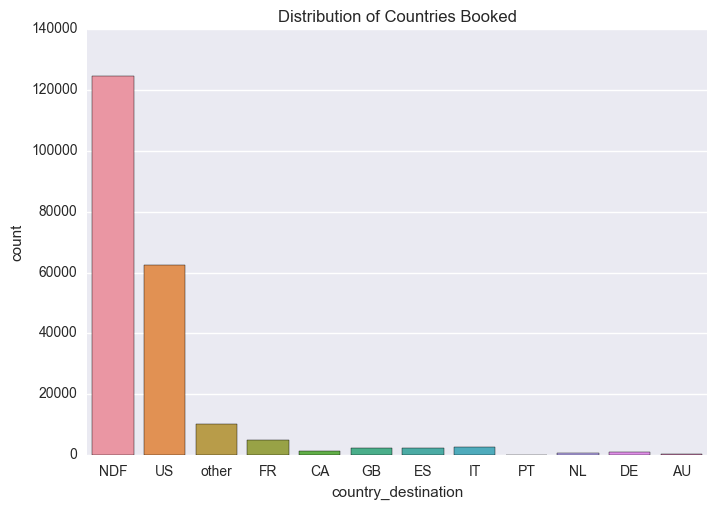

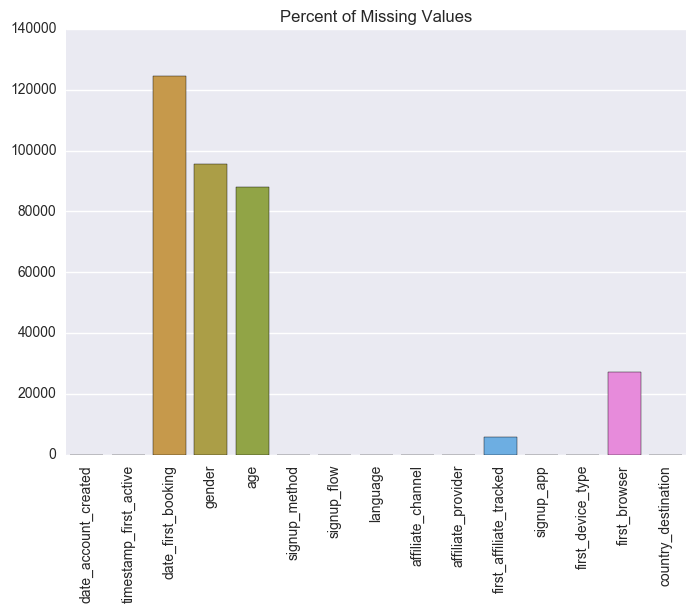

In [4]:
#distribution of countries
country_plot = sns.countplot(x='country_destination', data=all_data)
plt.title("Distribution of Countries Booked")
sns.plt.show()
#sns.barplot(x=all_data.country_destination.value_counts().index, y=all_data.country_destination.value_counts())

#number of NA
plot = sns.barplot(x=all_data.columns.values, y=all_data.isnull().sum())
plot.set_xticklabels(all_data.columns.values,rotation=30)
plt.title("Percent of Missing Values")
plt.xticks(rotation=90)


# total = float(len(all_data)) # one person per row 
# for p in plot.patches:
#     height = p.get_height()
#     per = height/total
#     if per > 0:
#         plot.text(p.get_x(), height+3, '%1.2f'%(per))
sns.plt.show()


## Data Pre-Processing

In [5]:
def remove_outliers(df, column, min_val, max_val):
    col_values = df[column].values
    df[column] = np.where(np.logical_or(col_values<=min_val, col_values>=max_val), np.NaN, col_values)
    return df


In [6]:
print("Fixing timestamps...")
all_data['date_account_created'] = pd.to_datetime(all_data['date_account_created'], format='%Y-%m-%d')
all_data['timestamp_first_active'] = pd.to_datetime(all_data['timestamp_first_active'], format='%Y%m%d%H%M%S')
all_data['date_account_created'].fillna(all_data.timestamp_first_active, inplace=True)

all_data.head()

Fixing timestamps...


,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,2010-06-28,2009-03-19 04:32:55,NaN,NaN,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,2011-05-25,2009-05-23 17:48:09,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,2010-09-14,2009-12-08 06:11:05,2010-02-18,NaN,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


Fixing age column...


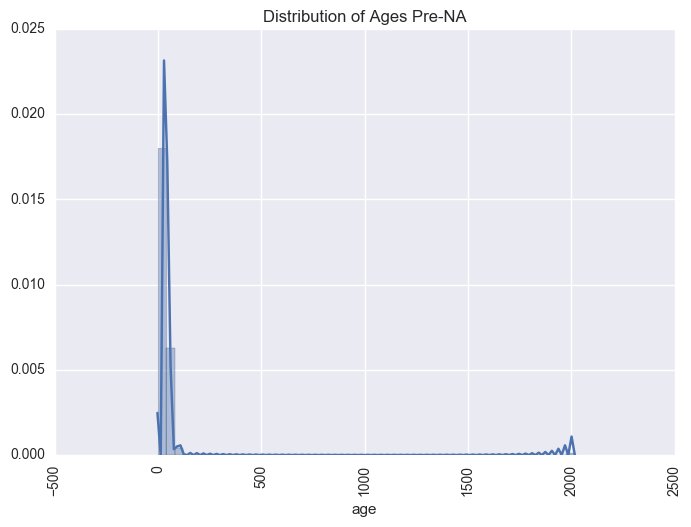

/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less_equal
  app.launch_new_instance()
/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()


Any NA values in age? True
Imputing missing data with mean age of  36.0
Any NA values in age? False


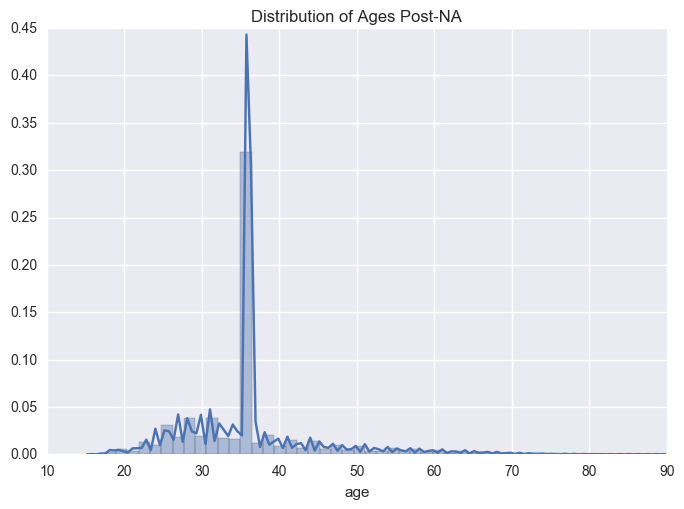

In [7]:
#observe age NA
print ("Fixing age column...")

pre_age_plot = sns.distplot(all_data.age.dropna(), bins =50 )
plt.title("Distribution of Ages Pre-NA")
plt.xticks(rotation=90)
sns.plt.show()

all_data = remove_outliers(df=all_data, column='age', min_val=15, max_val=90)
print "Any NA values in age?", all_data['age'].isnull().values.any()
mean_age = round(np.mean(all_data['age'].loc[all_data['age'].notnull()]))
print "Imputing missing data with mean age of ", mean_age
all_data['age'].fillna(mean_age, inplace=True)
all_data['age']= all_data['age'].astype(int)


print "Any NA values in age?", all_data['age'].isnull().values.any()
post_age_plot =sns.distplot(all_data.age, bins =50 )
plt.title("Distribution of Ages Post-NA")
sns.plt.show()


# all_data.loc[all_data.age > 90, 'age'] = np.nan
# all_data.loc[all_data.age < 19, 'age'] = np.nan
# post_age_plot =sns.distplot(all_data.age.dropna(), bins =50 )
# plt.title("Distribution of Ages Post-NA")
# # post_age_plot.xaxis.set_major_formatter(FormatStrFormatter('%0.0f'))
# plt.xticks(rotation=90)
# sns.plt.show()



In [8]:
def fix_first_browser(df):
    list = ['Chrome', 'Safari', 'Firefox', 'IE', 'Mobile Safari', 'Chrome Mobile', 'Android Browser']
    for i, row in df.iterrows():
        if row.first_browser not in list:
           df.set_value(i,'first_browser', 'other')
    return df

Fixing date_first_booking...
Fixing first_affiliate_tracked...
Any NA values? False


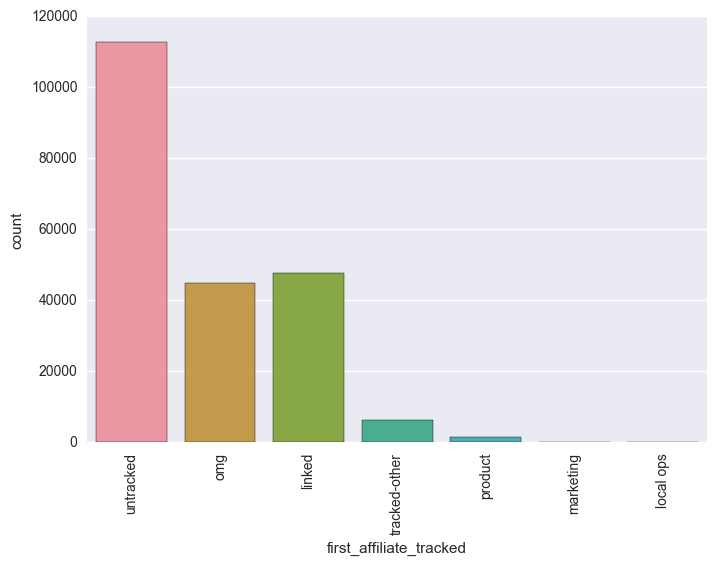

Fixing first_browser...


In [9]:
print("Fixing date_first_booking...")
all_data.drop('date_first_booking', axis=1, inplace=True)

print("Fixing first_affiliate_tracked...")
all_data['first_affiliate_tracked'].fillna(method = 'ffill', inplace = True)
print "Any NA values?", all_data['first_affiliate_tracked'].isnull().values.any()
affiliate_plot =sns.countplot(all_data['first_affiliate_tracked'])
plt.xticks(rotation=90)
sns.plt.show()
# print "Current NA count:", all_data['first_affiliate_tracked'].isnull().sum()
# all_data = all_data[all_data.first_affiliate_tracked.notnull()]
# print "New NA count:", all_data['first_affiliate_tracked'].isnull().sum()

print ("Fixing first_browser...")
all_data = fix_first_browser(all_data)

# print all_data.head()
# all_data['first_browser'].fillna(method = 'ffill', inplace = True)


In [10]:
print all_data['first_browser'].value_counts().index.tolist()


['Chrome', 'Safari', 'Firefox', 'other', 'IE', 'Mobile Safari', 'Chrome Mobile', 'Android Browser']


In [11]:
#fix datatypes
categorical_features = [
    'affiliate_channel',
    'affiliate_provider',
    'country_destination',
    'first_affiliate_tracked',
    'first_browser',
    'first_device_type',
    'gender',
    'language',
    'signup_app',
    'signup_method'
]

print("Converting objects to categories...")
for categorical_feature in categorical_features:
   all_data[categorical_feature] = all_data[categorical_feature].astype('category')


Converting objects to categories...


Adding new date fields...
Any NA values? False


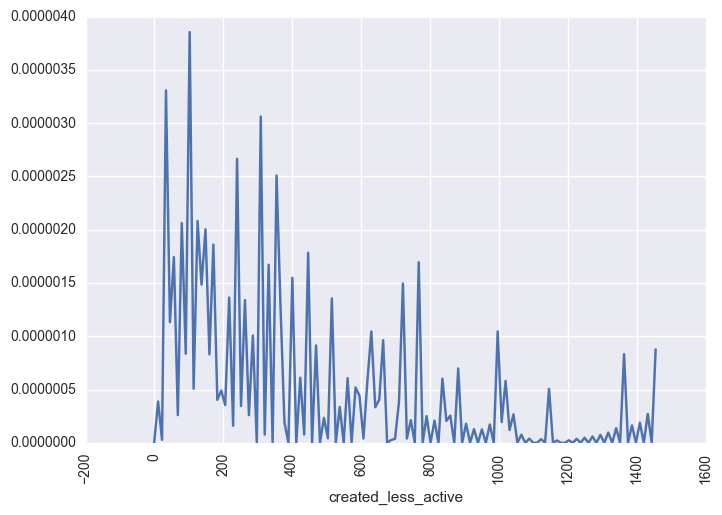

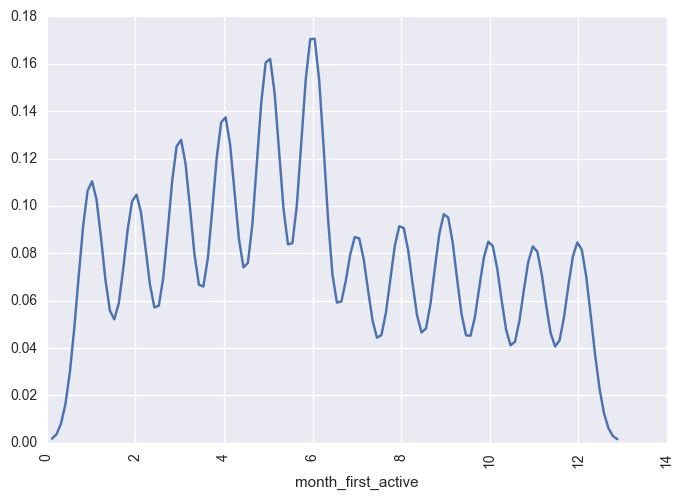

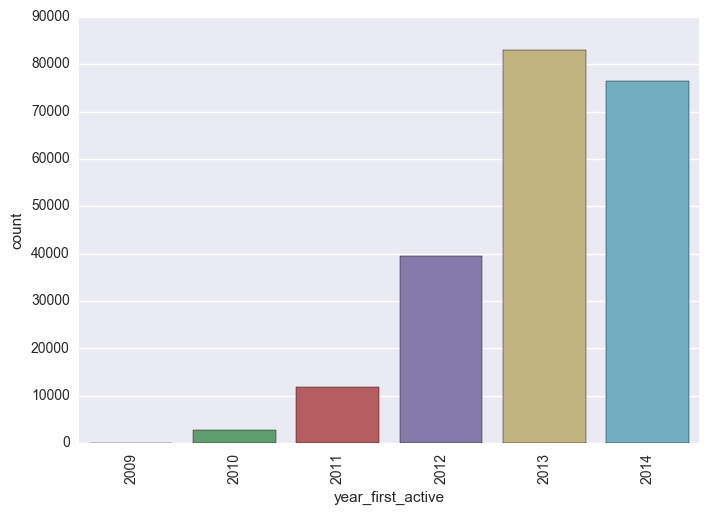

In [12]:
#extracting date values 
# Add new date related fields
print("Adding new date fields...")
all_data['day_account_created'] = all_data['date_account_created'].dt.weekday
all_data['month_account_created'] = all_data['date_account_created'].dt.month
all_data['quarter_account_created'] = all_data['date_account_created'].dt.quarter
all_data['year_account_created'] = all_data['date_account_created'].dt.year
all_data['hour_first_active'] = all_data['timestamp_first_active'].dt.hour
all_data['day_first_active'] = all_data['timestamp_first_active'].dt.weekday
all_data['month_first_active'] = all_data['timestamp_first_active'].dt.month
all_data['quarter_first_active'] = all_data['timestamp_first_active'].dt.quarter
all_data['year_first_active'] = all_data['timestamp_first_active'].dt.year
all_data['created_less_active'] = (all_data['date_account_created'] - all_data['timestamp_first_active']).dt.days

# Drop unnecessary columns
columns_to_drop = ['date_account_created', 'timestamp_first_active']
for column in columns_to_drop:
    if column in all_data.columns:
        all_data.drop(column, axis=1, inplace=True)

# all_data.head()
print "Any NA values?", all_data['first_affiliate_tracked'].isnull().values.any()

created_less_plot =sns.distplot(all_data['created_less_active'], hist = False)
plt.xticks(rotation=90)
sns.plt.show()

created_less_plot =sns.distplot(all_data['month_first_active'], hist = False)
plt.xticks(rotation=90)
sns.plt.show()

created_less_plot =sns.countplot(all_data['year_first_active'])
plt.xticks(rotation=90)
sns.plt.show()

# sns.regplot(all_data['created_less_active'],all_data['year_first_active'])
# plt.xticks(rotation=90)
# sns.plt.show()

In [13]:
# all_data['created_less_active'].value_counts().index.tolist()

Fixing gender...


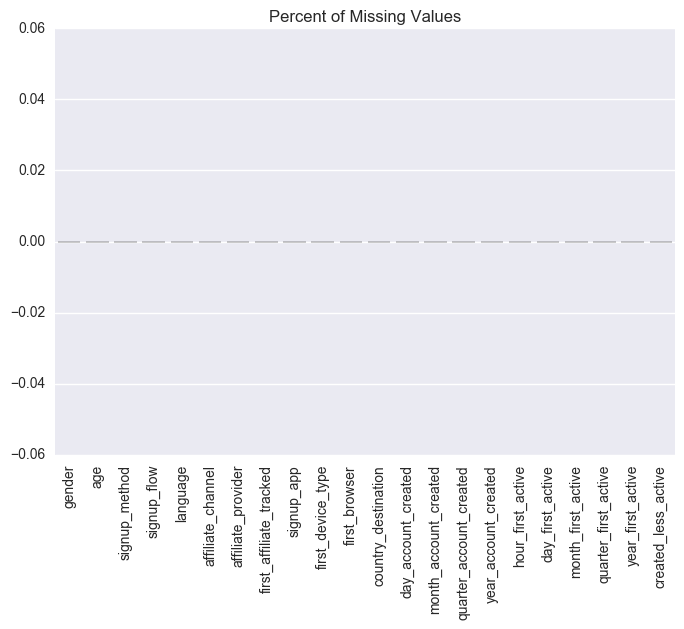

In [14]:
print("Fixing gender...")
pick_gender = ['FEMALE','MALE']
all_data['gender'].fillna(np.random.choice(pick_gender), inplace = True)

#updated missing values
plot = sns.barplot(x=all_data.columns.values, y=all_data.isnull().sum())
plot.set_xticklabels(all_data.columns.values,rotation=90)
plt.title("Percent of Missing Values")
sns.plt.show()

## Dummy Encode Categoricals

In [15]:
print "Generating dummy variables for categoricals..."
features = [
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'first_browser',
    'first_device_type',
    'gender',
    'language',
    'signup_app',
    'signup_method'
]
dummies = pd.get_dummies(all_data[features])

for feature in all_data[features]:
    all_data.drop(feature,axis = 1, inplace = True)

frames = [all_data, dummies]
data_with_dummies = pd.concat(frames, axis = 1)

# data_with_dummies.columns.tolist()
# print data_with_dummies['created_less_active']

Generating dummy variables for categoricals...


## Split the data!

In [16]:
n_train = int((0.7*len(all_data)))
print "training size should be, ", n_train

#randomize sampling
np.random.seed(0) 
data_with_dummies = data_with_dummies.reindex(np.random.permutation(data_with_dummies.index))

#split into training and testing

x_train= data_with_dummies.iloc[:n_train, data_with_dummies.columns != 'country_destination'] #get everything but country destination
print "X train size is", x_train.shape
x_train_target = data_with_dummies.iloc[:n_train, data_with_dummies.columns =='country_destination']
print "X train_target size is", x_train_target.shape


print "\nX test should be", data_with_dummies.shape[0]-n_train

x_test= data_with_dummies.iloc[n_train+1:, data_with_dummies.columns != 'country_destination'] #get everything but country destination
print "X test size is", x_test.shape
x_test_target = data_with_dummies.iloc[n_train+1:, data_with_dummies.columns =='country_destination']
print "X test_target size is", x_test_target.shape



training size should be,  149415
X train size is (149415, 97)
X train_target size is (149415, 1)

X test should be 64036
X test size is (64035, 97)
X test_target size is (64035, 1)


In [17]:
duplicate = all_data

In [23]:
from sklearn.metrics import classification_report
def get_metrics(model, x_test_target, x_test):
    #confusion matrix
    x_test_predict = model.predict(x_test)
    cm = confusion_matrix(x_test_target, x_test_predict)
    print "Confusion Matrix: \n",cm

    #mean accuracy
    acc = model.score(x_test, x_test_target)
    print "Mean accuracy: ",acc
    
    #precision/recall
    print "Precision: ", metrics.precision_score(x_test_target, x_test_predict, average = 'weighted')
    print "Recall: ", metrics.recall_score(x_test_target, x_test_predict, average = 'weighted')
    
    print classification_report(x_test_target, x_test_predict)

In [19]:
def get_importances(model, x_test):
    #feature importance
    print "Feature importance ranking: \n"
    feature_imp = model.feature_importances_

    for x in range (0, len(feature_imp)):
        print x_test.columns[x],":", feature_imp[x]
    
    importances = model.feature_importances_
    indices = np.argsort(importances)
    plt.figure(2)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), x_test[indices])
    plt.xlabel('Relative Importance')

In [20]:
def histogram_plot( model, x_test_target, x_test ):
    print "Test - Histogram of predicted probabilities:" 
    x_test_predict = model.predict_proba(x_test)[:, 1]
    plt.figure(1)
    plt.hist(x_test_predict, bins=8)
    plt.xlim(0, 1)
    plt.title('Histogram of predicted probabilities')
    plt.xlabel('Predicted probability country destination')
    plt.ylabel('Frequency')
    plt.show()
    plt.close() 

## Cross Validation Trees
### Let's find the best number of estimators

/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/ensemble/forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/ensemble/forest.py:408: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel

1


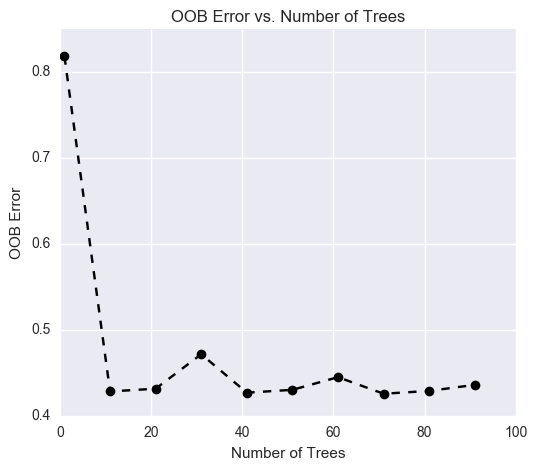

In [22]:
n_estimators = 100
forest = RandomForestClassifier(warm_start=True, oob_score=True)
errors = {}
for i in range(1, n_estimators + 1,10):
    forest.set_params(n_estimators=i)
    forest.fit(x_train, x_train_target)
    errors[i] = 1 - forest.oob_score_
max_err = max(errors.values())

for key, value in errors.iteritems():
    if value == max_err:
        marker = key
print marker

#plot the trees and error
plt.figure(figsize=(20,5))
error_plot = plt.subplot(131)
plt.plot(range(1, n_estimators + 1,10),
         errors.values(), 
         marker='o', 
         linestyle='--',
         c='black')
error_plot.set_title("OOB Error vs. Number of Trees")
error_plot.set_xlabel("Number of Trees")
error_plot.set_ylabel("OOB Error")





## Random Forest Attempt 1
### 40 trees. With One-hot encoding.

/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   16.3s finished
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    2.1s finished


Confusion Matrix: 
[[    0     0     0     1     2     0     1    87     0     0    63     2]
 [    0     0     1     2     4     1     1   254     0     0   179     4]
 [    0     1     0     0     2     1     2   174     0     0   124     7]
 [    0     0     1     2     5     4     1   417     2     1   241     7]
 [    3     3     5     5    12     2     5   880     0     0   588    13]
 [    2     0     0     4     4     4     4   391     0     1   274     6]
 [    2     2     1     2     9     3     3   487     1     0   319    11]
 [   13    55    39    87   156    77    91 29496    19     7  6897   407]
 [    1     1     0     0     2     3     0   106     0     0    85     4]
 [    0     0     0     0     0     1     0    43     0     0    21     1]
 [   10    24    16    49   111    53    55 10856     8     2  7297   273]
 [    0     2     3     7    26     6     9  1803     4     0  1118    51]]


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    2.2s finished


Mean accuracy:  0.575700788631
Precision:  0.5110752678
Recall:  0.575700788631
             precision    recall  f1-score   support

         AU       0.00      0.00      0.00       156
         CA       0.00      0.00      0.00       446
         DE       0.00      0.00      0.00       311
         ES       0.01      0.00      0.00       681
         FR       0.04      0.01      0.01      1516
         GB       0.03      0.01      0.01       690
         IT       0.02      0.00      0.01       840
        NDF       0.66      0.79      0.72     37344
         NL       0.00      0.00      0.00       202
         PT       0.00      0.00      0.00        66
         US       0.42      0.39      0.41     18754
      other       0.06      0.02      0.03      3029

avg / total       0.51      0.58      0.54     64035

Test - Histogram of predicted probabilities:


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    2.0s finished


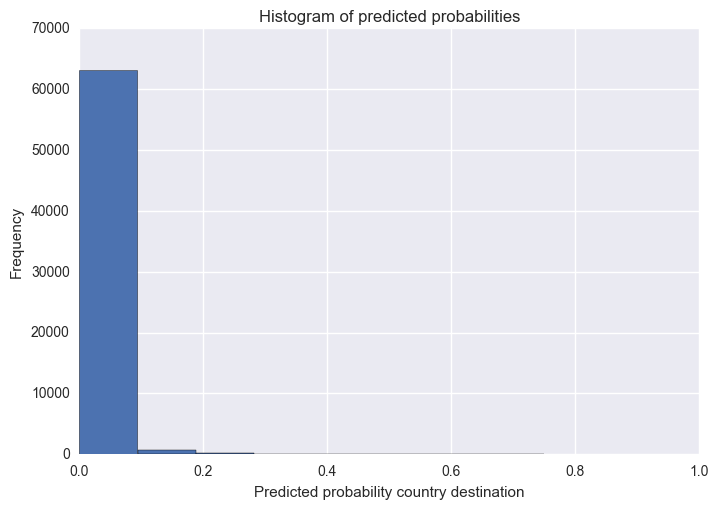

Feature importance ranking: 

age : 0.187350915157
signup_flow : 0.0175447742519
day_account_created : 0.0773457246022
month_account_created : 0.0573126908573
quarter_account_created : 0.0154671027928
year_account_created : 0.024307989904
hour_first_active : 0.227758810678
day_first_active : 0.0769354031244
month_first_active : 0.0570771749735
quarter_first_active : 0.0151427125453
year_first_active : 0.0249781881101
created_less_active : 0.000376282087771
affiliate_channel_api : 0.000811691125556
affiliate_channel_content : 0.00293487821629
affiliate_channel_direct : 0.00405444335643
affiliate_channel_other : 0.00244656539951
affiliate_channel_remarketing : 0.00114215484395
affiliate_channel_sem-brand : 0.00549842889771
affiliate_channel_sem-non-brand : 0.00502976601822
affiliate_channel_seo : 0.0035611390465
affiliate_provider_baidu : 4.14472966343e-05
affiliate_provider_bing : 0.00168897080551
affiliate_provider_craigslist : 0.00154943403072
affiliate_provider_daum : 1.41904141138e-

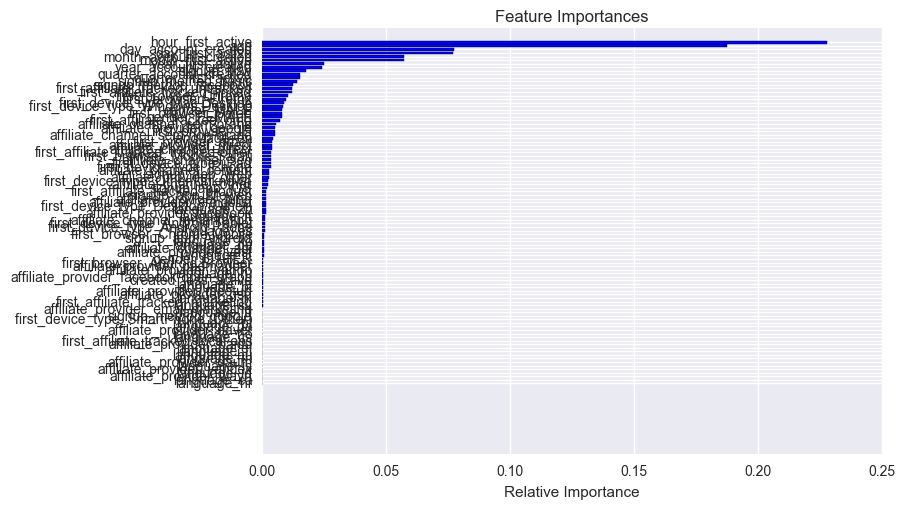

In [24]:
rf1 = RandomForestClassifier(n_estimators=40, oob_score = True, verbose=1)
rf1.fit(x_train, x_train_target)

get_metrics(rf1, x_test_target, x_test)

##oob score
# print "Oob error: ",1 - rf1.oob_score_

histogram_plot(rf1, x_test_target, x_test)

get_importances(rf1, x_test)

# target_names = ['class 0', 'class 1', 'class 2']








## Random Forest Attempt 2
### 70 trees. With One-hot encoding.

/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   25.1s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   34.6s finished
[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    8.9s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   12.2s finished


Confusion Matrix: 
[[    0     0     0     0     3     0     1    83     0     0    67     2]
 [    0     2     0     2     4     2     3   255     0     1   174     3]
 [    1     1     0     1     3     0     2   172     0     0   128     3]
 [    0     1     0     3     2     3     5   412     1     1   243    10]
 [    1     4     3     7    10     7     6   873     3     0   584    18]
 [    2     1     0     4     2     3     6   404     1     1   262     4]
 [    0     2     2     2     5     2     3   488     0     0   324    12]
 [   20    46    38    84   178    62   110 29487    30     4  6888   397]
 [    0     1     0     0     3     1     2    97     0     0    89     9]
 [    0     0     0     0     0     0     0    43     0     0    21     2]
 [    8    25    21    49    96    45    55 10852    16     2  7326   259]
 [    0     3     2     5    20     5    12  1804     5     0  1117    56]]


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    7.9s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   11.2s finished


Mean accuracy:  0.576091200125
Precision:  0.511920113937
Recall:  0.576091200125
Oob error:  0.430739885554


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    7.3s finished


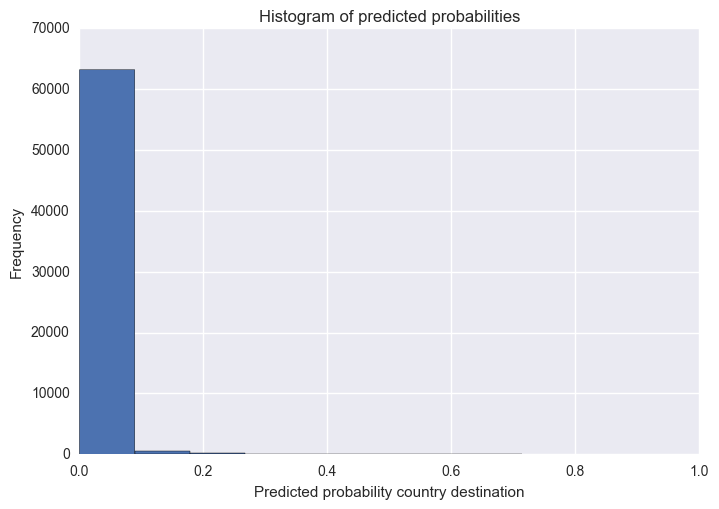


Feature importance ranking: 

age : 0.191414908317
signup_flow : 0.0172047528309
day_account_created : 0.0777406523678
month_account_created : 0.0557979131142
quarter_account_created : 0.014860876777
year_account_created : 0.0229087967091
hour_first_active : 0.229509868606
day_first_active : 0.0778207072423
month_first_active : 0.0560675699295
quarter_first_active : 0.0146171774213
year_first_active : 0.0227965258572
created_less_active : 0.00039587477468
affiliate_channel_api : 0.000859334454004
affiliate_channel_content : 0.00297356838406
affiliate_channel_direct : 0.00385822669426
affiliate_channel_other : 0.00234012701041
affiliate_channel_remarketing : 0.00110518947352
affiliate_channel_sem-brand : 0.00536139809734
affiliate_channel_sem-non-brand : 0.00500107939871
affiliate_channel_seo : 0.00342516805557
affiliate_provider_baidu : 3.75769930746e-05
affiliate_provider_bing : 0.0016922777058
affiliate_provider_craigslist : 0.00144435523153
affiliate_provider_daum : 1.29112499195e-

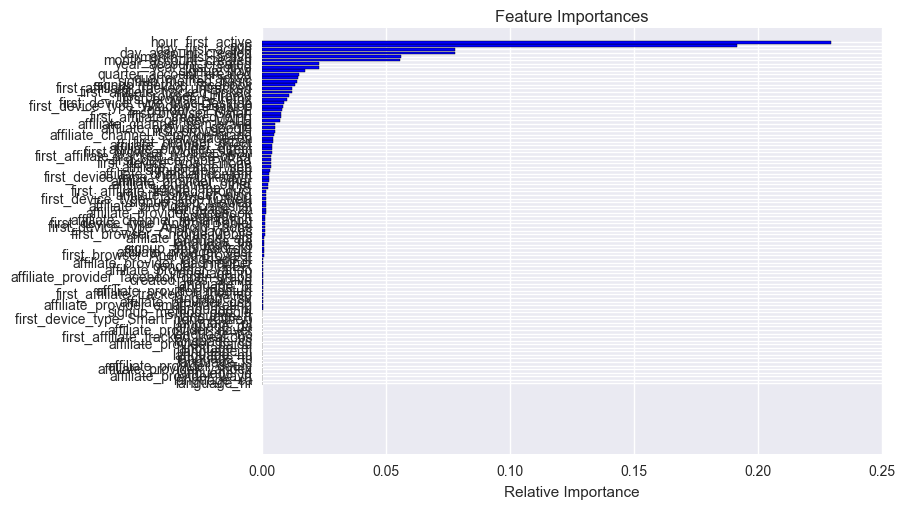

In [40]:
rf1 = RandomForestClassifier(n_estimators=70, oob_score = True, verbose=1)
rf1.fit(x_train, x_train_target)

get_metrics(rf1, x_test_target, x_test)

#oob score
print "Oob error: ",1 - rf1.oob_score_

histogram_plot(rf1, x_test_target, x_test)
print 

get_importances(rf1, x_test)

# evaluate_threshold(rf1, x_test_target, x_test, .3)






## Random Forest Attempt 3
### 100 trees. With One-hot encoding.

/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   23.1s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   46.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.4s finished


Confusion Matrix: 
[[    0     0     0     0     3     0     0    81     0     0    70     2]
 [    0     2     0     3     2     3     3   253     0     0   175     5]
 [    1     1     0     0     2     0     2   163     0     0   140     2]
 [    0     0     0     2     6     2     4   406     1     1   251     8]
 [    3     2     2     5    10     6     5   882     2     0   583    16]
 [    2     1     0     2     3     4     5   411     0     1   254     7]
 [    0     3     1     2     7     3     0   495     0     0   314    15]
 [   19    43    42    77   170    69   106 29561    24     6  6855   372]
 [    1     1     0     0     3     1     2    97     0     0    91     6]
 [    0     0     0     0     0     1     0    42     0     0    21     2]
 [    9    22    19    46   105    41    51 10834    17     2  7356   252]
 [    0     3     3     4    16     5    11  1832     3     0  1100    52]]


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.5s finished


Mean accuracy:  0.577605996721
Precision:  0.512495313937
Recall:  0.577605996721
Oob error:  0.426697453402


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.8s finished


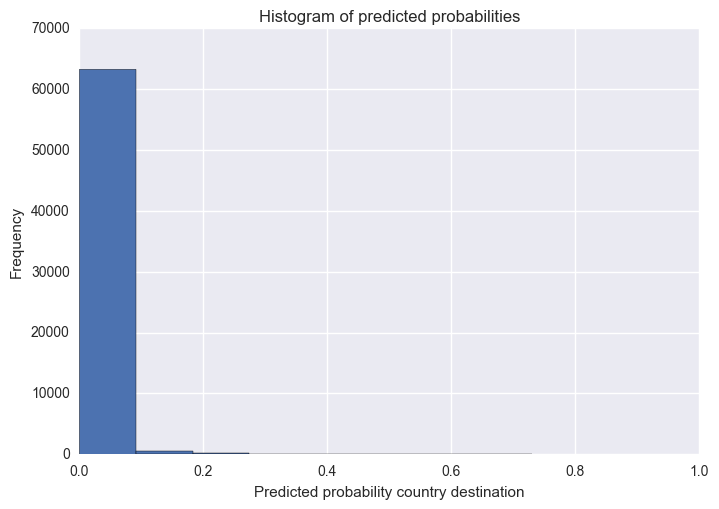


Feature importance ranking: 

age : 0.191414908317
signup_flow : 0.0172047528309
day_account_created : 0.0777406523678
month_account_created : 0.0557979131142
quarter_account_created : 0.014860876777
year_account_created : 0.0229087967091
hour_first_active : 0.229509868606
day_first_active : 0.0778207072423
month_first_active : 0.0560675699295
quarter_first_active : 0.0146171774213
year_first_active : 0.0227965258572
created_less_active : 0.00039587477468
affiliate_channel_api : 0.000859334454004
affiliate_channel_content : 0.00297356838406
affiliate_channel_direct : 0.00385822669426
affiliate_channel_other : 0.00234012701041
affiliate_channel_remarketing : 0.00110518947352
affiliate_channel_sem-brand : 0.00536139809734
affiliate_channel_sem-non-brand : 0.00500107939871
affiliate_channel_seo : 0.00342516805557
affiliate_provider_baidu : 3.75769930746e-05
affiliate_provider_bing : 0.0016922777058
affiliate_provider_craigslist : 0.00144435523153
affiliate_provider_daum : 1.29112499195e-

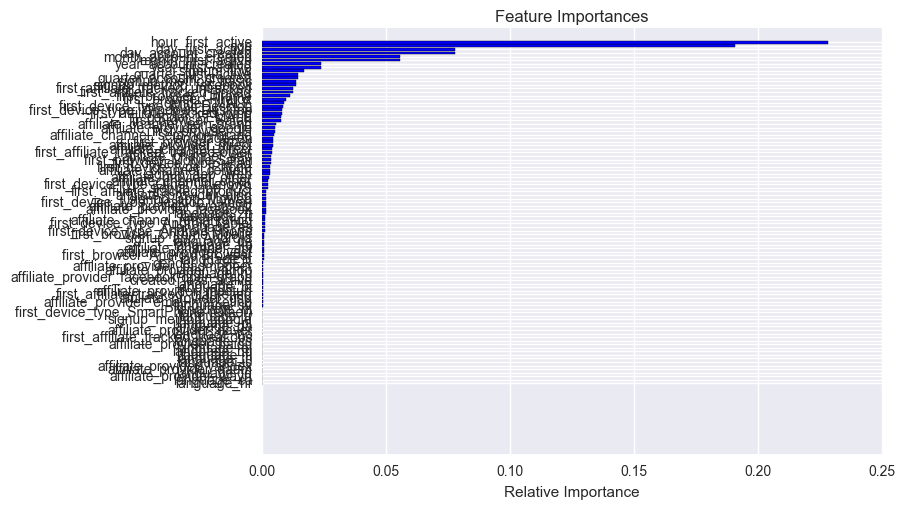

In [41]:
rf2 = RandomForestClassifier(n_estimators=100, oob_score=True, verbose=1)
rf2.fit(x_train, x_train_target)

get_metrics(rf2, x_test_target, x_test)

#oob score
print "Oob error: ",1 - rf2.oob_score_

histogram_plot(rf2, x_test_target, x_test)
print 

get_importances(rf2, x_test)

## Random Forest Attempt 4
### 70 trees. With One-hot encoding. Balanced Classes.

/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   26.2s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   37.8s finished
[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    6.7s finished


Confusion Matrix: 
[[    0     0     0     0     2     0     0    96     0     0    56     2]
 [    0     1     0     2     4     1     4   281     0     0   147     6]
 [    0     1     0     0     2     0     2   195     0     0   109     2]
 [    0     0     0     3     4     2     4   434     0     1   229     4]
 [    1     3     2     5    11     4     3   974     2     0   496    15]
 [    2     0     0     1     5     4     5   448     0     0   221     4]
 [    0     1     4     3     3     3     3   534     0     0   276    13]
 [   15    65    57   110   245   111   162 29660    38     6  6338   537]
 [    1     0     0     0     3     2     2   115     0     0    75     4]
 [    0     0     0     0     0     0     1    45     0     0    19     1]
 [    5    23    21    44   110    49    53 11910    13     1  6282   243]
 [    3     6     3     7    20     9     9  1943     2     0   966    61]]


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    4.8s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    6.2s finished


Mean accuracy:  0.562582962442
Precision:  0.496349211983
Recall:  0.562582962442
Oob error:  0.44212428471


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    3.0s finished


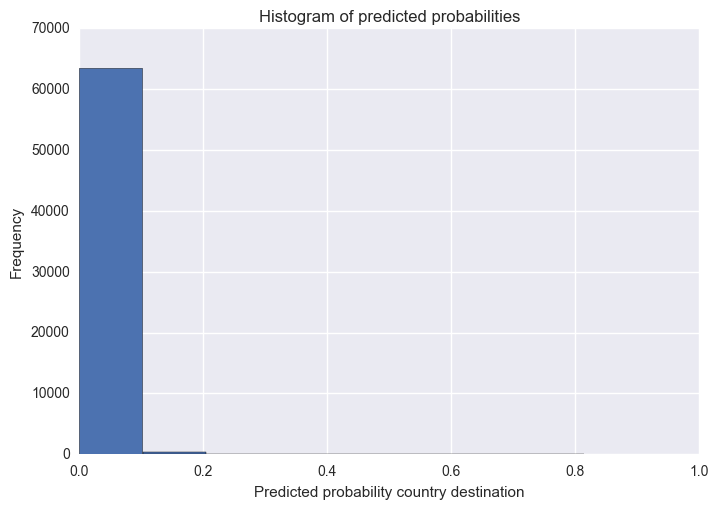


Feature importance ranking: 

age : 0.191414908317
signup_flow : 0.0172047528309
day_account_created : 0.0777406523678
month_account_created : 0.0557979131142
quarter_account_created : 0.014860876777
year_account_created : 0.0229087967091
hour_first_active : 0.229509868606
day_first_active : 0.0778207072423
month_first_active : 0.0560675699295
quarter_first_active : 0.0146171774213
year_first_active : 0.0227965258572
created_less_active : 0.00039587477468
affiliate_channel_api : 0.000859334454004
affiliate_channel_content : 0.00297356838406
affiliate_channel_direct : 0.00385822669426
affiliate_channel_other : 0.00234012701041
affiliate_channel_remarketing : 0.00110518947352
affiliate_channel_sem-brand : 0.00536139809734
affiliate_channel_sem-non-brand : 0.00500107939871
affiliate_channel_seo : 0.00342516805557
affiliate_provider_baidu : 3.75769930746e-05
affiliate_provider_bing : 0.0016922777058
affiliate_provider_craigslist : 0.00144435523153
affiliate_provider_daum : 1.29112499195e-

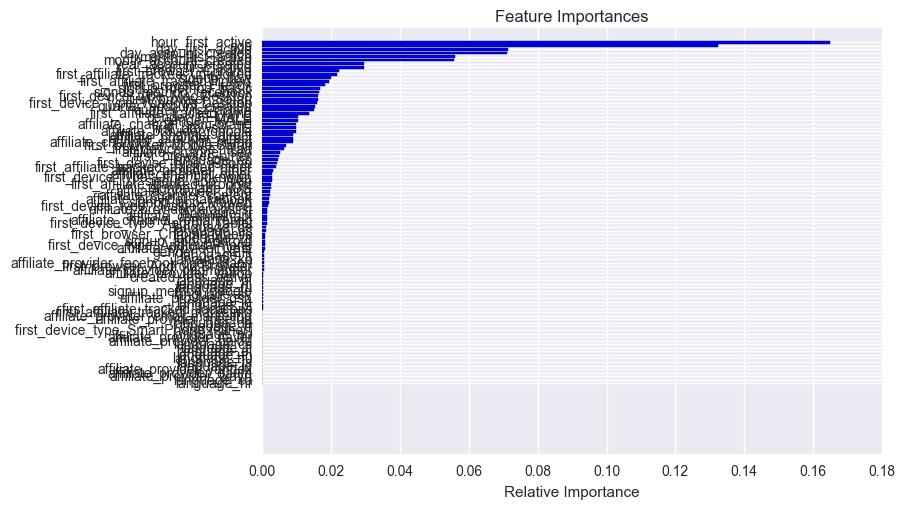

In [42]:
rf3 = RandomForestClassifier(n_estimators=70, verbose=1, oob_score = True, class_weight="balanced")
rf3.fit(x_train, x_train_target)

get_metrics(rf3, x_test_target, x_test)

#oob score
print "Oob error: ",1 - rf3.oob_score_

histogram_plot(rf3, x_test_target, x_test)
print 

get_importances(rf3, x_test)

## Grid Search Attempt 1
### Not balanced

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Confusion Matrix: 
[[    0     0     0     0     0     0     0    92     0     0    64     0]
 [    0     0     0     0     0     0     0   287     0     0   159     0]
 [    0     0     0     0     0     0     0   192     0     0   119     0]
 [    0     0     0     0     0     0     0   459     0     0   222     0]
 [    0     0     0     0     0     0     0  1024     0     0   492     0]
 [    0     0     0     0     0     0     0   461     0     0   229     0]
 [    0     0     0     0     0     0     0   565     0     0   275     0]
 [    0     0     0     0     0     0     0 33381     0     0  3963     0]
 [    0     0     0     0

/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 0.527179642938
Recall:  0.622581400796


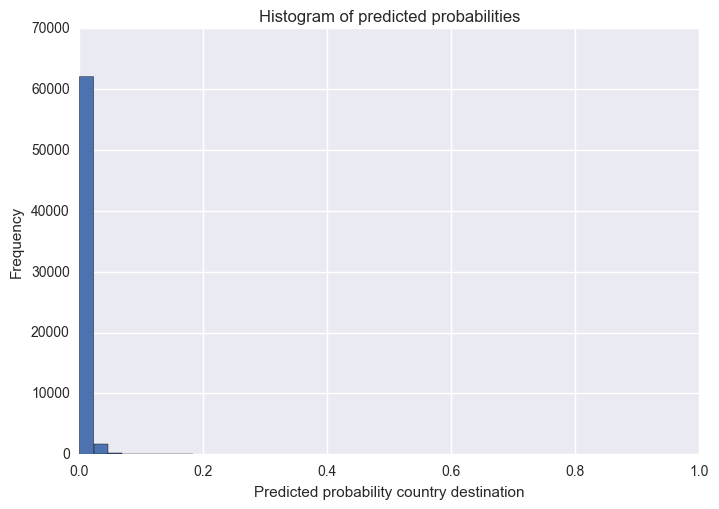


Feature importance ranking: 

age : 0.191414908317
signup_flow : 0.0172047528309
day_account_created : 0.0777406523678
month_account_created : 0.0557979131142
quarter_account_created : 0.014860876777
year_account_created : 0.0229087967091
hour_first_active : 0.229509868606
day_first_active : 0.0778207072423
month_first_active : 0.0560675699295
quarter_first_active : 0.0146171774213
year_first_active : 0.0227965258572
created_less_active : 0.00039587477468
affiliate_channel_api : 0.000859334454004
affiliate_channel_content : 0.00297356838406
affiliate_channel_direct : 0.00385822669426
affiliate_channel_other : 0.00234012701041
affiliate_channel_remarketing : 0.00110518947352
affiliate_channel_sem-brand : 0.00536139809734
affiliate_channel_sem-non-brand : 0.00500107939871
affiliate_channel_seo : 0.00342516805557
affiliate_provider_baidu : 3.75769930746e-05
affiliate_provider_bing : 0.0016922777058
affiliate_provider_craigslist : 0.00144435523153
affiliate_provider_daum : 1.29112499195e-

AttributeError: 'GridSearchCV' object has no attribute 'feature_importances_'

In [48]:
rf_grid = RandomForestClassifier()
param_grid = {
                 'n_estimators': [70,100],
                 'max_depth': [10, 20, 30],
                'min_samples_split':[2,4,6],
             }
grid_clf = GridSearchCV(rf_grid, param_grid)
labels = x_train_target['country_destination']
grid_clf.fit(x_train.values, labels)
print grid_clf.best_estimator_

get_metrics(grid_clf, x_test_target, x_test)

histogram_plot(grid_clf, x_test_target, x_test)
print 

get_importances(grid_clf.best_estimator_, x_test)

## Grid Search Attempt 2
### Balanced

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=30, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Confusion Matrix: 
[[    0     1     0     0     3     0     0    90     0     0    57     5]
 [    0     1     0     3     6     2     3   284     0     0   140     7]
 [    0     0     0     0     1     1     4   186     0     0   116     3]
 [    0     0     1     4     8     2     4   429     1     1   223     8]
 [    1     5     1     6    16    10     4   949     2     0   500    22]
 [    2     0     0     1     3     4     4   435     0     0   235     6]
 [    0     3     2     3     5     4     3   517     0     0   291    12]
 [   18    68    66   117   252   123   180 29551    44     8  6388   529]
 [    1     0     0 

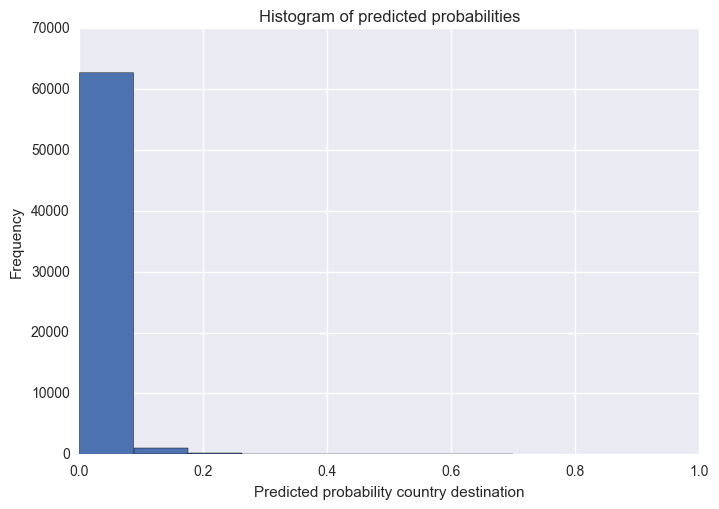


Feature importance ranking: 

age : 0.191414908317
signup_flow : 0.0172047528309
day_account_created : 0.0777406523678
month_account_created : 0.0557979131142
quarter_account_created : 0.014860876777
year_account_created : 0.0229087967091
hour_first_active : 0.229509868606
day_first_active : 0.0778207072423
month_first_active : 0.0560675699295
quarter_first_active : 0.0146171774213
year_first_active : 0.0227965258572
created_less_active : 0.00039587477468
affiliate_channel_api : 0.000859334454004
affiliate_channel_content : 0.00297356838406
affiliate_channel_direct : 0.00385822669426
affiliate_channel_other : 0.00234012701041
affiliate_channel_remarketing : 0.00110518947352
affiliate_channel_sem-brand : 0.00536139809734
affiliate_channel_sem-non-brand : 0.00500107939871
affiliate_channel_seo : 0.00342516805557
affiliate_provider_baidu : 3.75769930746e-05
affiliate_provider_bing : 0.0016922777058
affiliate_provider_craigslist : 0.00144435523153
affiliate_provider_daum : 1.29112499195e-

AttributeError: 'GridSearchCV' object has no attribute 'feature_importances_'

In [49]:
rf_grid = RandomForestClassifier(class_weight="balanced")
param_grid = {
                 'n_estimators': [70,100],
                 'max_depth': [10, 20, 30],
                'min_samples_split':[2,4,6],
             }
grid_clf = GridSearchCV(rf_grid, param_grid)
labels = x_train_target['country_destination']
grid_clf.fit(x_train.values, labels)
print grid_clf.best_estimator_

get_metrics(grid_clf, x_test_target, x_test)

histogram_plot(grid_clf, x_test_target, x_test)
print 

get_importances(grid_clf.best_estimator_, x_test)

## GridSearch attempt 3
### with only decision trees

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Confusion Matrix: 
[[    0     0     0     0     0     0     0    74     0     0    82     0]
 [    0     0     0     0     0     0     0   229     0     0   217     0]
 [    0     0     0     0     1     0     0   187     0     0   123     0]
 [    0     0     0     1     0     0     0   409     0     0   271     0]
 [    0     0     0     1     2     2     1   863     0     0   644     3]
 [    0     1     0     0     0     0     0   394     0     0   295     0]
 [    0     0     0     0     0     0     0   477     0     0   363     0]
 [    3     6     6     4     5     5    11 31659     0     0  5638     7]
 [    0     0     1     0     0     0     0    89     0     0   112     0]
 [    0     0     0     0     0   

/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 0.54869240624
Recall:  0.627641133755
Test - Histogram of predicted probabilities:


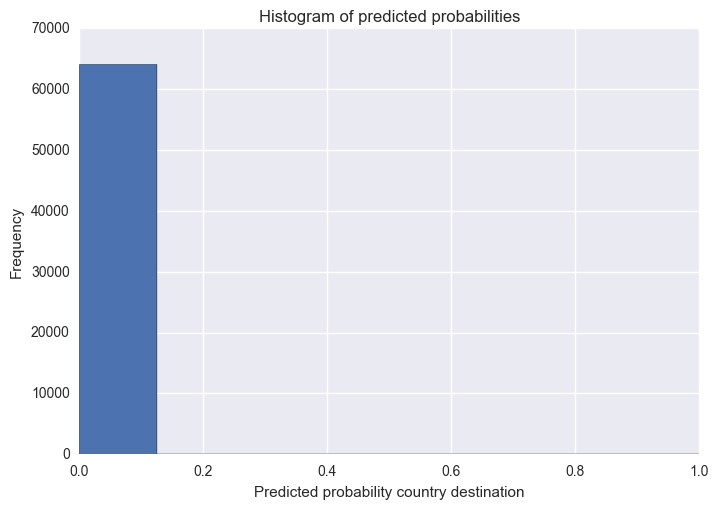


Feature importance ranking: 



AttributeError: 'GridSearchCV' object has no attribute 'feature_importances_'

In [32]:
rf_grid = DecisionTreeClassifier()
param_grid = {
                 'criterion': ['gini', 'entropy'],
                 'max_depth': [10, 20, 30],
                'min_samples_split':[2,4,6],
             }
grid_clf = GridSearchCV(rf_grid, param_grid)
labels = x_train_target['country_destination']
grid_clf.fit(x_train.values, labels)
print grid_clf.best_estimator_

get_metrics(grid_clf, x_test_target, x_test)

histogram_plot(grid_clf, x_test_target, x_test)
print 

get_importances(grid_clf.best_estimator_, x_test)

## GridSearch attempt 4
### with only decision trees and balanced classes

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=30, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Confusion Matrix: 
[[    0     3     3     2     4     2     1    66     5     0    63     7]
 [    1    10     8     8    25     9    13   191     2     0   154    25]
 [    0     6     0     5    16     2    11   138     2     0   105    26]
 [    2     7     7    18    30     9    20   310     4     0   229    45]
 [   10    18    22    29    59    21    36   676    10     3   529   103]
 [    4     7     6    11    27    17    25   313     2     1   241    36]
 [    2     8    12    16    37    16    32   346     5     1   297    68]
 [  123   294   226   478   974   472   597 22914   168    50  9042  2006]
 [    0     0     5     4     8     3     4    91     0     1    71    15]
 [    2     1

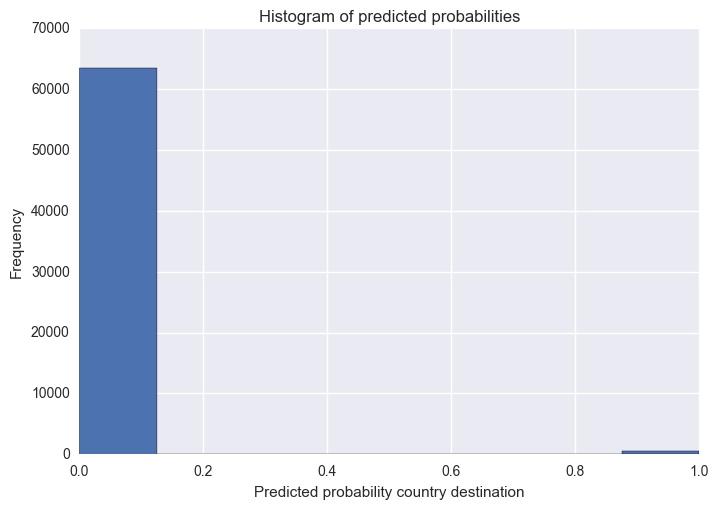


Feature importance ranking: 



AttributeError: 'GridSearchCV' object has no attribute 'feature_importances_'

In [33]:
rf_grid = DecisionTreeClassifier(class_weight = 'balanced')
param_grid = {
                 'criterion': ['gini', 'entropy'],
                 'max_depth': [10, 20, 30],
                'min_samples_split':[2,4,6],
             }
grid_clf = GridSearchCV(rf_grid, param_grid)
labels = x_train_target['country_destination']
grid_clf.fit(x_train.values, labels)
print grid_clf.best_estimator_

get_metrics(grid_clf, x_test_target, x_test)

histogram_plot(grid_clf, x_test_target, x_test)
print 

get_importances(grid_clf.best_estimator_, x_test)

## Boosting trees Attempt 1
### Adaboost

/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix: 
[[    0     0     0     0     2     0     1    87     0     0    65     1]
 [    0     1     0     2     2     0     3   264     0     0   167     7]
 [    0     0     0     0     2     2     1   175     0     0   127     4]
 [    0     0     0     3     3     0     2   434     0     0   232     7]
 [    0     0     0     2    10     4     4   939     0     0   548     9]
 [    2     0     0     3     3     2     4   411     0     1   256     8]
 [    0     1     0     1     5     2     2   516     0     0   301    12]
 [   10    28    17    38   141    45    76 28839    14     1  7755   380]
 [    0     1     0     0     1     1     2   113     0     0    80     4]
 [    0     0     0     0     0     0     0    45     0     0    19     2]
 [    3    12     7    23    73    22    37 11417     9     1  6913   237]
 [    1     1     2     4    13     7     8  1871     3     0  1071    48]]
Mean accuracy:  0.559350355274
Precision:  0.493395100215
Recall:  0.55935035527

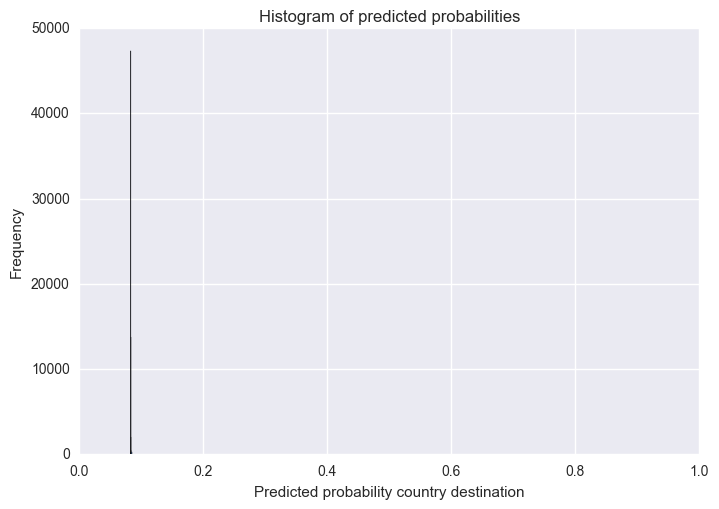


Feature importance ranking: 

age : 0.191414908317
signup_flow : 0.0172047528309
day_account_created : 0.0777406523678
month_account_created : 0.0557979131142
quarter_account_created : 0.014860876777
year_account_created : 0.0229087967091
hour_first_active : 0.229509868606
day_first_active : 0.0778207072423
month_first_active : 0.0560675699295
quarter_first_active : 0.0146171774213
year_first_active : 0.0227965258572
created_less_active : 0.00039587477468
affiliate_channel_api : 0.000859334454004
affiliate_channel_content : 0.00297356838406
affiliate_channel_direct : 0.00385822669426
affiliate_channel_other : 0.00234012701041
affiliate_channel_remarketing : 0.00110518947352
affiliate_channel_sem-brand : 0.00536139809734
affiliate_channel_sem-non-brand : 0.00500107939871
affiliate_channel_seo : 0.00342516805557
affiliate_provider_baidu : 3.75769930746e-05
affiliate_provider_bing : 0.0016922777058
affiliate_provider_craigslist : 0.00144435523153
affiliate_provider_daum : 1.29112499195e-

/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/tree/tree.py:475: RuntimeWarning: invalid value encountered in divide
  return self.tree_.compute_feature_importances()


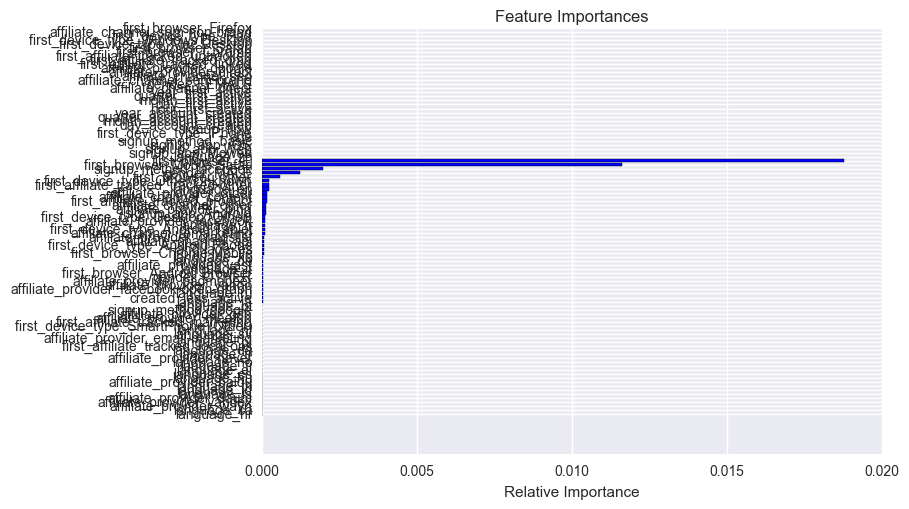

In [51]:
ada = AdaBoostClassifier(
    RandomForestClassifier(maxdepth = 20, min_samples_split = 6),
    n_estimators=100,
    learning_rate=1.2,
    algorithm="SAMME")

ada.fit(x_train, x_train_target)

get_metrics(ada, x_test_target, x_test)

histogram_plot(ada, x_test_target, x_test)
print 

get_importances(ada, x_test)

## Boosting trees Attempt 2
### Adaboost

In [55]:
ada = AdaBoostClassifier(
    RandomForestClassifier(),
    n_estimators=100,
    learning_rate=1.2,
    algorithm="SAMME")

ada.fit(x_train, x_train_target)

get_metrics(ada, x_test_target, x_test)

histogram_plot(ada, x_test_target, x_test)
print 

get_importances(ada, x_test)

/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix: 
[[    0     0     0     0     3     0     0    95     0     0    57     1]
 [    0     1     0     1     2     0     2   298     0     0   136     6]
 [    0     0     0     0     3     0     3   201     0     0   103     1]
 [    0     0     0     2     2     2     2   470     0     1   195     7]
 [    0     1     1     1    10     5     4  1029     0     0   451    14]
 [    2     0     0     2     2     3     3   467     0     1   204     6]
 [    0     0     2     1     6     1     0   571     0     0   248    11]
 [   12    27    24    43   142    46    83 30258    16     4  6344   345]
 [    0     0     0     1     2     0     2   125     0     0    68     4]
 [    0     0     0     0     0     0     0    48     0     0    18     0]
 [    6    15     9    30    81    25    42 12633    10     1  5669   233]
 [    1     2     2     4    11     3    11  2092     0     0   851    52]]
Mean accuracy:  0.56211446865
Precision:  0.486481481753
Recall:  0.56211446865


KeyboardInterrupt: 

## Boosting trees Attempt 3
### Adaboost with balanced trees and constraints

/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix: 
[[    0     0     0     0     3     0     1    94     0     0    53     5]
 [    0     1     0     1     2     0     2   292     0     0   144     4]
 [    0     0     0     1     3     0     1   199     0     0   104     3]
 [    0     0     0     2     3     1     1   471     0     0   197     6]
 [    0     1     1     4    11     5     2  1038     1     0   438    15]
 [    2     0     0     2     1     4     4   470     0     1   199     7]
 [    0     0     1     1     5     1     2   564     0     0   255    11]
 [   12    34    33    59   183    70   108 29900    24     6  6499   416]
 [    0     0     0     0     1     1     2   125     0     0    68     5]
 [    0     0     0     0     0     0     1    46     0     0    18     1]
 [    6    20    14    30    91    33    46 12492    13     1  5776   232]
 [    1     3     2     3    15     5    11  2056     2     0   889    42]]
Mean accuracy:  0.558101038495
Precision:  0.485053327957
Recall:  0.55810103849

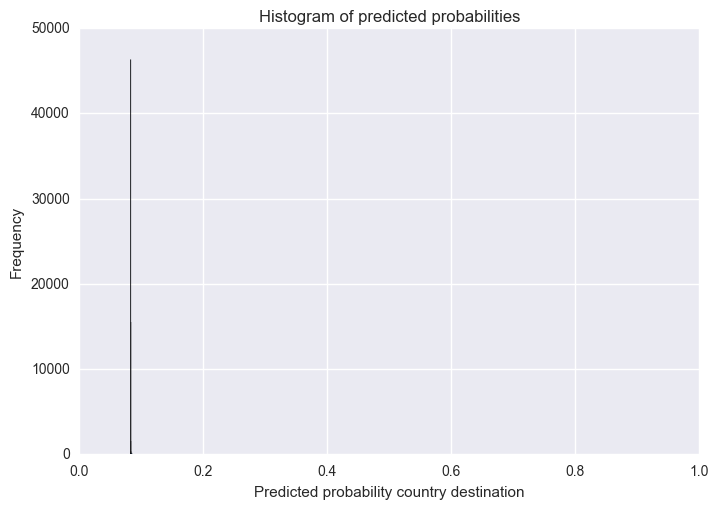


Feature importance ranking: 

age : 0.191414908317
signup_flow : 0.0172047528309
day_account_created : 0.0777406523678
month_account_created : 0.0557979131142
quarter_account_created : 0.014860876777
year_account_created : 0.0229087967091
hour_first_active : 0.229509868606
day_first_active : 0.0778207072423
month_first_active : 0.0560675699295
quarter_first_active : 0.0146171774213
year_first_active : 0.0227965258572
created_less_active : 0.00039587477468
affiliate_channel_api : 0.000859334454004
affiliate_channel_content : 0.00297356838406
affiliate_channel_direct : 0.00385822669426
affiliate_channel_other : 0.00234012701041
affiliate_channel_remarketing : 0.00110518947352
affiliate_channel_sem-brand : 0.00536139809734
affiliate_channel_sem-non-brand : 0.00500107939871
affiliate_channel_seo : 0.00342516805557
affiliate_provider_baidu : 3.75769930746e-05
affiliate_provider_bing : 0.0016922777058
affiliate_provider_craigslist : 0.00144435523153
affiliate_provider_daum : 1.29112499195e-

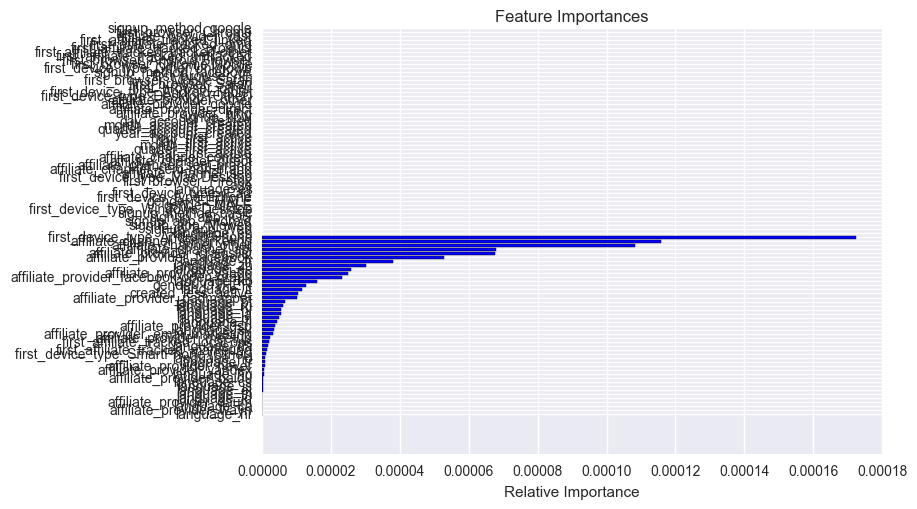

In [54]:
ada = AdaBoostClassifier(
    RandomForestClassifier(max_depth = 30, min_samples_split = 2, class_weight = 'balanced'),
    n_estimators = 100,
    learning_rate=1.2,
    algorithm="SAMME")

ada.fit(x_train, x_train_target)

get_metrics(ada, x_test_target, x_test)

histogram_plot(ada, x_test_target, x_test)
print 

get_importances(ada, x_test)

## Boosting trees Attempt 4
### Boosting with decision trees

/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix: 
[[    0     0     0     0     3     1     1    99     0     0    52     0]
 [    1     0     0     2     2     1     2   301     0     0   128     9]
 [    1     0     0     0     7     1     4   201     0     0    92     5]
 [    0     0     1     1     5     0     2   468     3     0   190    11]
 [    1     1     2     7     4     3     5  1042     1     0   437    13]
 [    2     1     0     2     6     4     7   466     1     0   194     7]
 [    0     2     1     1     8     1     5   575     0     0   235    12]
 [   22    50    38    90   171    76    91 29820    26    10  6462   488]
 [    0     0     0     1     3     3     1   130     0     0    60     4]
 [    0     0     0     0     0     0     0    46     0     0    20     0]
 [   12    34    19    45   124    51    65 12499    15     3  5603   284]
 [    2     4     2     4    24     9    16  2045     3     1   863    56]]
Mean accuracy:  0.554275005856
Precision:  0.483036452452
Recall:  0.55427500585

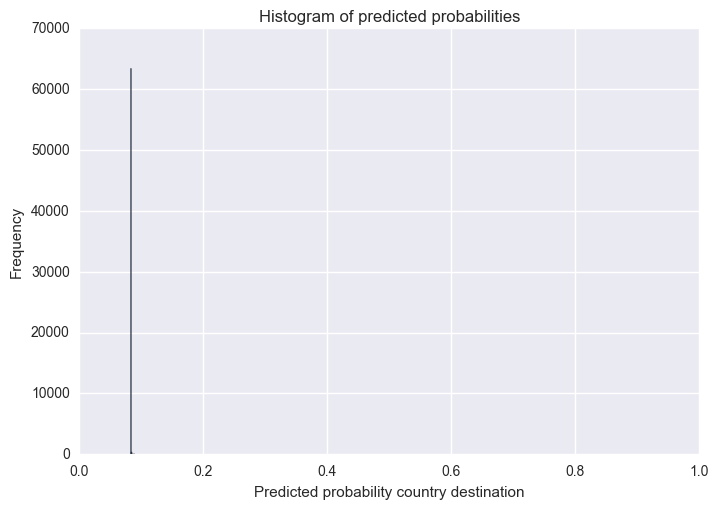


Feature importance ranking: 



/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/tree/tree.py:475: RuntimeWarning: invalid value encountered in divide
  return self.tree_.compute_feature_importances()


age : nan
signup_flow : nan
day_account_created : nan
month_account_created : nan
quarter_account_created : nan
year_account_created : nan
hour_first_active : nan
day_first_active : nan
month_first_active : nan
quarter_first_active : nan
year_first_active : nan
created_less_active : nan
affiliate_channel_api : nan
affiliate_channel_content : nan
affiliate_channel_direct : nan
affiliate_channel_other : nan
affiliate_channel_remarketing : nan
affiliate_channel_sem-brand : nan
affiliate_channel_sem-non-brand : nan
affiliate_channel_seo : nan
affiliate_provider_baidu : 4.95776681729e-07
affiliate_provider_bing : nan
affiliate_provider_craigslist : nan
affiliate_provider_daum : 4.32352641224e-07
affiliate_provider_direct : nan
affiliate_provider_email-marketing : 3.13788644594e-06
affiliate_provider_facebook : nan
affiliate_provider_facebook-open-graph : 1.44633284561e-05
affiliate_provider_google : nan
affiliate_provider_gsp : 5.41915511608e-07
affiliate_provider_meetup : nan
affiliate_pro

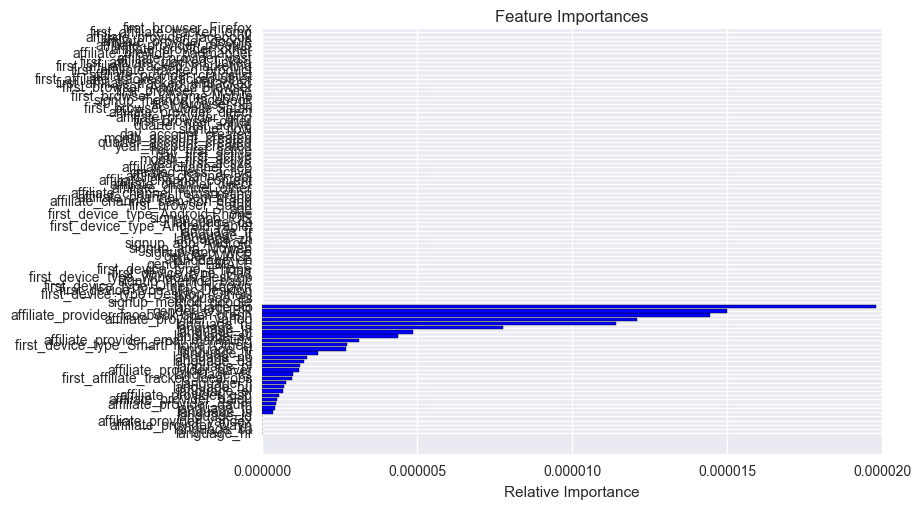

In [36]:
ada = AdaBoostClassifier(
    DecisionTreeClassifier(),
    n_estimators = 100,
    learning_rate=1.2,
    algorithm="SAMME")

ada.fit(x_train, x_train_target)

get_metrics(ada, x_test_target, x_test)

histogram_plot(ada, x_test_target, x_test)
print 

get_importances(ada, x_test)

## QDA

/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Confusion Matrix: 
[[    6     0     0     0     0     1     0     0     3   146     0     0]
 [   24     5     1     0     1     0     0     0     2   412     1     0]
 [   23     3     1     0     0     0     0     0     3   280     1     0]
 [   25    10     4     1     2     0     0     1     5   633     0     0]
 [   45    18     4     0     0     0     0     0    11  1438     0     0]
 [   14     3     1     0     0     0     0     0     7   662     2     1]
 [   17    14     4     1     1     0     0     0    11   788     2     2]
 [ 2316  1102   191    17    50    38    33    32   568 32963    14    20]
 [    6     4     0     0     0     0     0     0     2   190     0     0]
 [    4     1     0     0     0     0     0     0     1    60     0     0]
 [  774   396    66     7    21    23    10     6   176 17236    28    11]
 [  136    51     9     0     7     2     3     1    35  2783     1     1]]
Mean accuracy:  0.00212383852581
Precision:  0.635712285345
Recall:  0.002123838

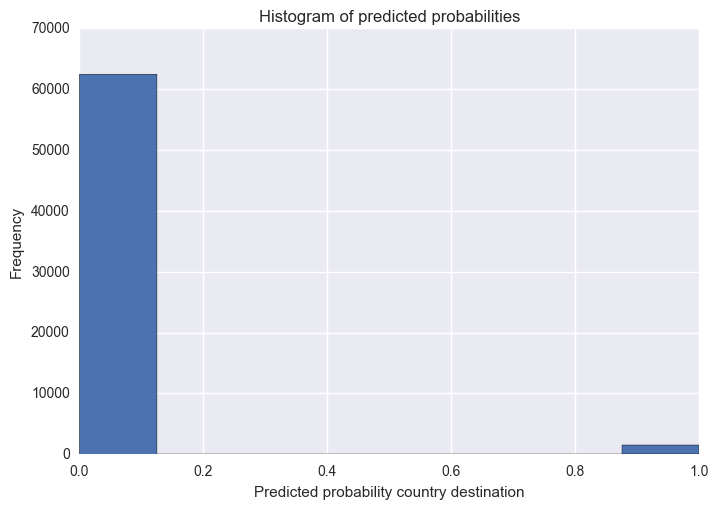

In [25]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import numpy as np

clf = QuadraticDiscriminantAnalysis()

clf.fit(x_train, x_train_target)

get_metrics(clf, x_test_target, x_test)

histogram_plot(clf, x_test_target, x_test)

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# knn = KNeighborsClassifier()
# knn.fit(x_train, x_train_target) 
# KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
#            metric_params=None, n_jobs=1, n_neighbors=7, p=2,
#            weights='uniform')
# knn.predict(x_test)

knn_grid = KNeighborsClassifier()
param_grid = {
                 'n_neighbors': [5,10],
                 'p': [1, 2],
             }
grid_clf = GridSearchCV(knn_grid, param_grid)
labels = x_train_target['country_destination']
grid_clf.fit(x_train.values, labels)
print grid_clf.best_estimator_

get_metrics(grid_clf, x_test_target, x_test)

histogram_plot(grid_clf.best_estimator_, x_test_target, x_test)
print 


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=1,
           weights='uniform')
Confusion Matrix: 
[[    0     0     0     0     0     0     0   112     0     0    44     0]
 [    0     0     0     0     0     0     0   309     0     0   136     1]
 [    0     1     0     0     0     0     2   203     0     0   104     1]
 [    0     0     0     1     2     0     0   497     0     0   179     2]
 [    0     0     0     1     2     1     0  1095     0     0   416     1]
 [    0     0     0     0     1     0     0   498     0     0   191     0]
 [    0     0     0     1     0     2     0   615     0     0   220     2]
 [    0     1     2     5    18     4     1 32477     0     0  4814    22]
 [    0     0     0     0     0     0     0   138     0     0    64     0]
 [    0     0     0     0     0     1     0    50     0     0    15     0]
 [    0     0     0     7    19     2     2 13233     0     0  546

/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 0.503558735304
Recall:  0.592629030999


/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

         AU       0.00      0.00      0.00       156
         CA       0.00      0.00      0.00       446
         DE       0.00      0.00      0.00       311
         ES       0.07      0.00      0.00       681
         FR       0.04      0.00      0.00      1516
         GB       0.00      0.00      0.00       690
         IT       0.00      0.00      0.00       840
        NDF       0.63      0.87      0.73     37344
         NL       0.00      0.00      0.00       202
         PT       0.00      0.00      0.00        66
         US       0.44      0.29      0.35     18754
      other       0.11      0.00      0.00      3029

avg / total       0.50      0.59      0.53     64035

Test - Histogram of predicted probabilities:


## XGBoost


/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/preprocessing/label.py:108: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
Confusion Matrix: 
[[    0     0     0     0     0     0     0    76     0     0    80     0]
 [    0     0     0     0     0     0     0   242     0     0   204     0]
 [    0     0     0     0     0     0     0   179     0     0   132     0]
 [    0     0     0     0     0     0     0   421     0     0   260     0]
 [    0     0     0     0     0     0     0   900     0     0   616     0]
 [    0     0     0     0     0     0     0   400     0     0   290     0]
 [    0     0     0     0     0     0     0   481     0     0   359     0]
 [    0     0     0     0     0     0     0 32242     0     0  5102     0]
 [    0     0     0     0     0     0     0   101 

/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 0.541218845569
Recall:  0.63170141329
Test - Histogram of predicted probabilities:


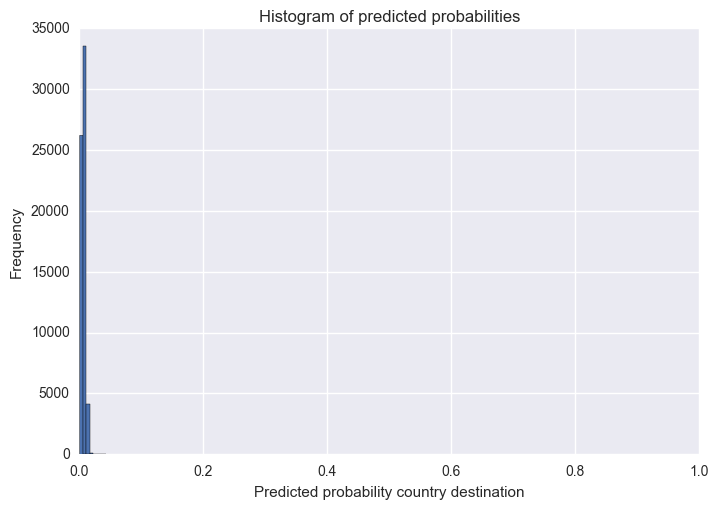


Feature importance ranking: 



NameError: global name 'rf1' is not defined

In [23]:
import xgboost

model = xgboost.XGBClassifier()
model.fit(x_train, x_train_target)

print model

get_metrics(model, x_test_target, x_test)

histogram_plot(model, x_test_target, x_test)
print 

get_importances(model, x_test)

## Gradient Boosting Classifier

/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix: 
[[    0     0     0     2   154     0     0     0     0     0     0     0]
 [    0     0     0    12   434     0     0     0     0     0     0     0]
 [    0     0     0     4   307     0     0     0     0     0     0     0]
 [    0     0     0    12   669     0     0     0     0     0     0     0]
 [    0     0     0    25  1491     0     0     0     0     0     0     0]
 [    0     0     0    14   676     0     0     0     0     0     0     0]
 [    0     0     0    19   821     0     0     0     0     0     0     0]
 [    0     0     0   617 36727     0     0     0     0     0     0     0]
 [    0     0     0     4   198     0     0     0     0     0     0     0]
 [    0     0     0     1    65     0     0     0     0     0     0     0]
 [    0     0     0   458 18296     0     0     0     0     0     0     0]
 [    0     0     0    71  2958     0     0     0     0     0     0     0]]
Mean accuracy:  0.0234715390021
Precision:  0.000665118517563
Recall:  0.0234715

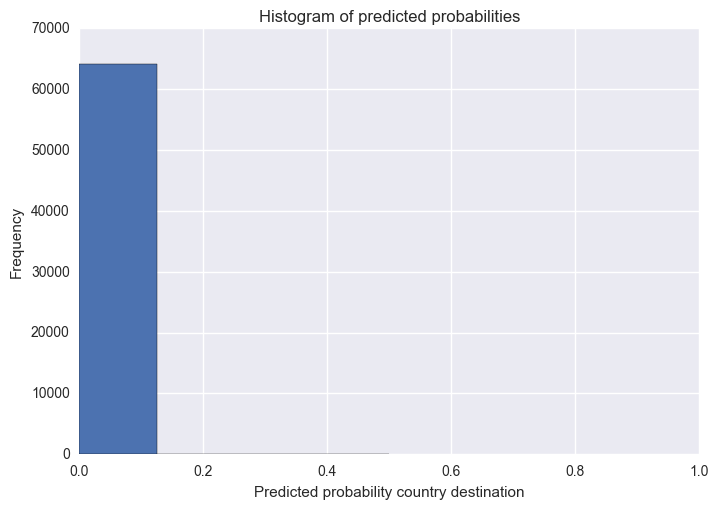


Feature importance ranking: 



NameError: global name 'rf1' is not defined

In [24]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0)

model.fit(x_train, x_train_target)

get_metrics(model, x_test_target, x_test)

histogram_plot(model, x_test_target, x_test)
print 

get_importances(model, x_test)
